In [ ]:
# Configuración y rutas

from pathlib import Path
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import sys

# Ruta del proyecto
PROJECT_DIR = Path("/home/TFM_Laura_Monne").resolve()
RESULTS_DIR = PROJECT_DIR / "results"
OUTPUTS_DIR = PROJECT_DIR / "outputs"

# Selecciona el dataset cuyas explicaciones quieres analizar:
#   - "blood"
#   - "retina"
#   - "breast"
DATASET = "blood"

print("Proyecto :", PROJECT_DIR)
print("Resultados:", RESULTS_DIR)
print("Outputs   :", OUTPUTS_DIR)
print("Dataset   :", DATASET)

assert RESULTS_DIR.exists(), "❌ Falta la carpeta results/ (entrena primero con train.py)"
assert OUTPUTS_DIR.exists(), "❌ Falta la carpeta outputs/ (ejecuta primero python xai_explanations.py)"

# Aseguramos que los módulos locales (prepare_data, data_utils, resnet18) se puedan importar
if str(PROJECT_DIR) not in sys.path:
    sys.path.append(str(PROJECT_DIR))


Proyecto : /home/TFM_Laura_Monne
Resultados: /home/TFM_Laura_Monne/results
Outputs   : /home/TFM_Laura_Monne/outputs


In [ ]:
# Carga de metadatos de explicaciones

# Leemos el JSON específico del dataset seleccionado
meta_path = OUTPUTS_DIR / f"explanations_results_{DATASET}.json"
assert meta_path.exists(), f"❌ No existe {meta_path}. Ejecuta antes: python xai_explanations.py --dataset {DATASET}"

with open(meta_path, "r") as f:
    explanations_meta = json.load(f)

print(f"Nº de entradas en {meta_path.name}: {len(explanations_meta)}")
print("Ejemplo de entrada:\n")
print(explanations_meta[0])

Nº de entradas en explanations_results.json: 500
Ejemplo de entrada:

{'global_idx': 0, 'bucket': 'blood', 'true_class': 3, 'pred_class': 3, 'methods': {'gradcam': {'path': 'outputs/gradcam/img_0_class_3.png', 'status': 'success'}, 'gradcampp': {'path': 'outputs/gradcampp/img_0_class_3.png', 'status': 'success'}, 'integrated_gradients': {'path': 'outputs/integrated_gradients/img_0_class_3.png', 'status': 'success'}, 'saliency': {'path': 'outputs/saliency/img_0_class_3.png', 'status': 'success'}}}


In [46]:
# Resumen de lo que tenemos

from collections import Counter

true_classes = [e["true_class"] for e in explanations_meta]
pred_classes = [e["pred_class"] for e in explanations_meta]

acc_explicadas = sum(int(t == p) for t, p in zip(true_classes, pred_classes)) / len(true_classes)
print(f"Accuracy dentro de las {len(true_classes)} muestras explicadas: {acc_explicadas*100:.2f}%")

# Rangos por dataset
BLOOD_RANGE = range(0, 8)
RETINA_RANGE = range(8, 13)
BREAST_RANGE = range(13, 15)

def contar_por_rango(rango, labels):
    return sum(1 for c in labels if c in rango)

print("\nDistribución de verdaderas clases en las 500 muestras:")
print(f"  BLOODMNIST  (0–7)  : {contar_por_rango(BLOOD_RANGE, true_classes)}")
print(f"  RETINAMNIST (8–12) : {contar_por_rango(RETINA_RANGE, true_classes)}")
print(f"  BREASTMNIST (13–14): {contar_por_rango(BREAST_RANGE, true_classes)}")

Accuracy dentro de las 500 muestras explicadas: 80.80%

Distribución de verdaderas clases en las 500 muestras:
  BLOODMNIST  (0–7)  : 300
  RETINAMNIST (8–12) : 150
  BREASTMNIST (13–14): 50


In [47]:
# Buscamos ejemplos por dataset:

BLOOD_RANGE = range(0, 8)
RETINA_RANGE = range(8, 13)
BREAST_RANGE = range(13, 15)

ejemplos = {
    "blood_ok": None,
    "retina_ok": None,
    "breast_ok": None,
    "retina_mal": None,  # ejemplo donde falle Retina
}

for i, e in enumerate(explanations_meta):
    y_true = e["true_class"]
    y_pred = e["pred_class"]
    
    if y_true in BLOOD_RANGE and y_true == y_pred and ejemplos["blood_ok"] is None:
        ejemplos["blood_ok"] = i
    if y_true in RETINA_RANGE and y_true == y_pred and ejemplos["retina_ok"] is None:
        ejemplos["retina_ok"] = i
    if y_true in BREAST_RANGE and y_true == y_pred and ejemplos["breast_ok"] is None:
        ejemplos["breast_ok"] = i
    if y_true in RETINA_RANGE and y_true != y_pred and ejemplos["retina_mal"] is None:
        ejemplos["retina_mal"] = i

ejemplos

{'blood_ok': 0, 'retina_ok': 301, 'breast_ok': 451, 'retina_mal': 300}

In [48]:
# Explicación de un índice:

def mostrar_explicaciones_de_idx(idx):
    """
    Muestra las 4 explicaciones (GradCAM, GradCAM++, IG, Saliency)
    para la entrada explanations_meta[idx].
    """
    entry = explanations_meta[idx]
    
    # Recuperamos campos de forma segura, por si alguna clave no existe
    image_idx  = entry.get("image_idx", idx)
    true_class = entry.get("true_class", "?")
    pred_class = entry.get("pred_class", "?")
    
    print(f"Imagen idx={image_idx} | true_class={true_class} | pred_class={pred_class}")
    
    # Nos quedamos solo con métodos que tengan status=success y path definido
    raw_methods = entry.get("methods", {})
    methods = {
        name: info
        for name, info in raw_methods.items()
        if info.get("status") == "success" and "path" in info
    }
    
    if not methods:
        print("⚠ Esta entrada no tiene imágenes de explicación guardadas.")
        return
    
    fig, axes = plt.subplots(1, len(methods), figsize=(4*len(methods), 4))
    if len(methods) == 1:
        axes = [axes]  # para un solo método
    
    fig.suptitle(f"Explicaciones para sample {idx} (image_idx={image_idx})", fontsize=14)
    
    for ax, (mname, minfo) in zip(axes, methods.items()):
        img_rel_path = minfo.get("path", None)
        img_path = PROJECT_DIR / img_rel_path
        
        if not img_path.exists():
            ax.set_title(f"{mname}\n(no se encontró la imagen)")
            ax.axis("off")
            continue
        
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(mname)
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()



=== blood_ok (idx=0) ===
Imagen idx=0 | true_class=3 | pred_class=3


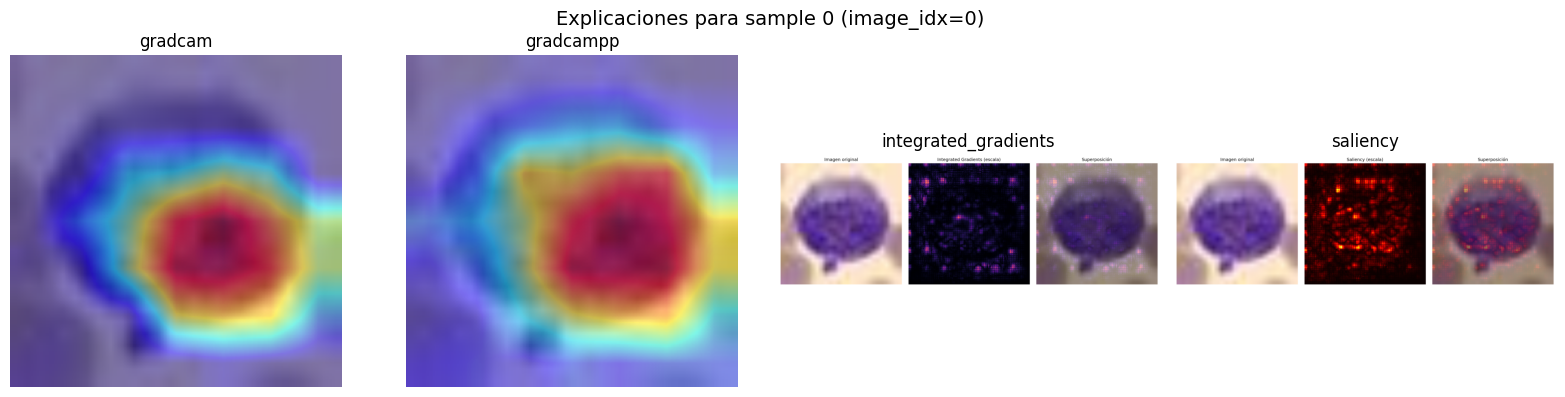


=== retina_ok (idx=301) ===
Imagen idx=301 | true_class=9 | pred_class=9


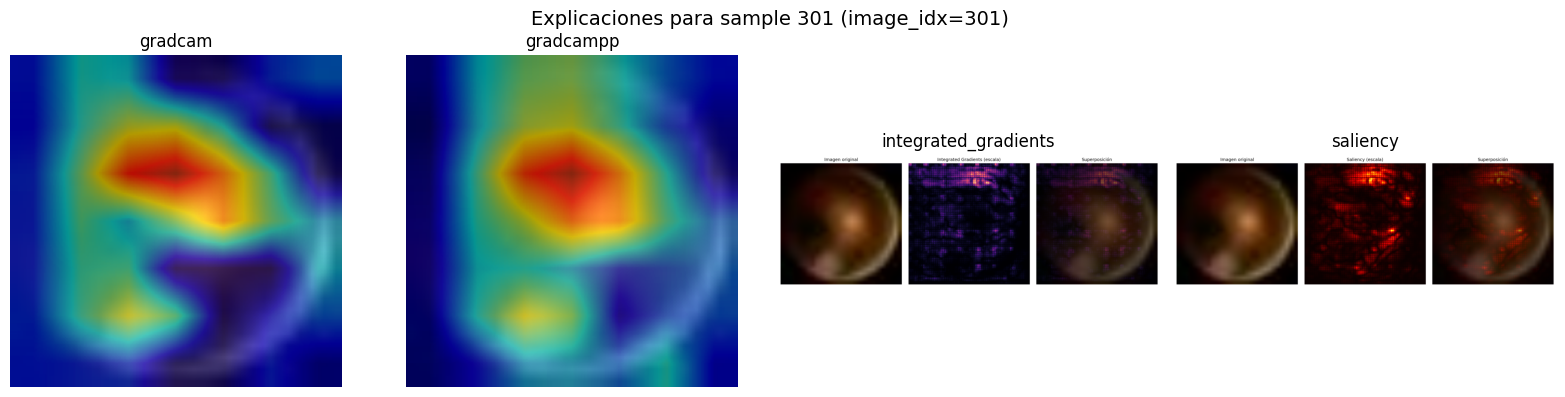


=== breast_ok (idx=451) ===
Imagen idx=451 | true_class=14 | pred_class=14


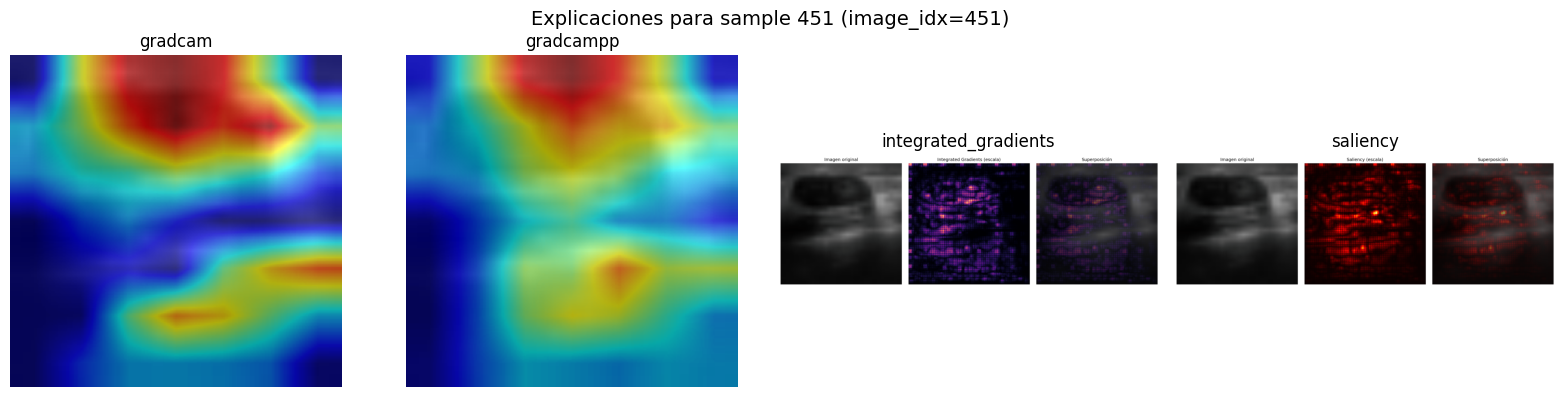


=== retina_mal (idx=300) ===
Imagen idx=300 | true_class=10 | pred_class=8


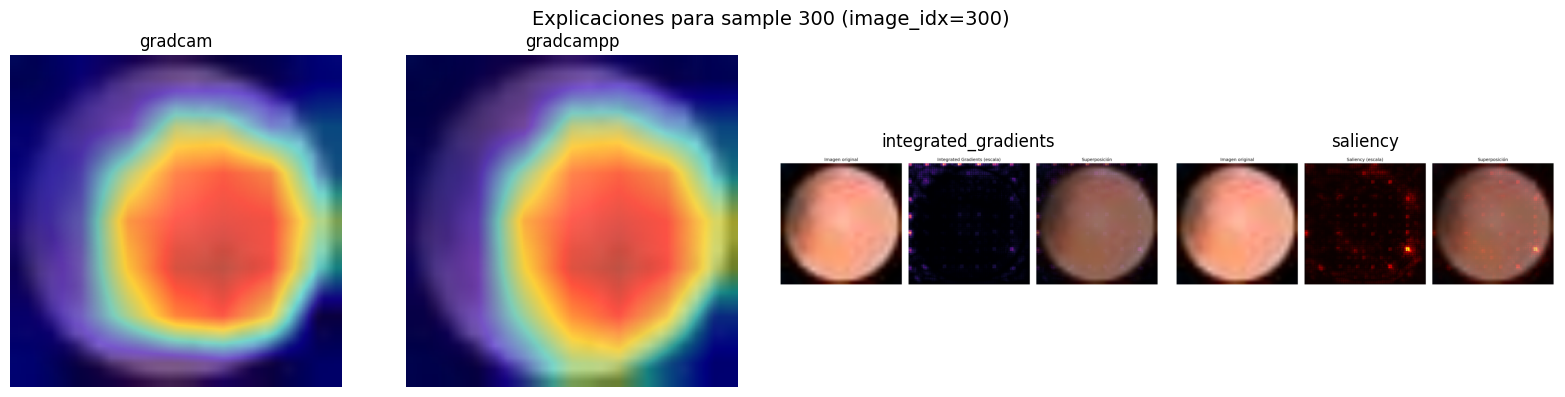

In [49]:
for nombre, idx in ejemplos.items():
    if idx is not None:
        print(f"\n=== {nombre} (idx={idx}) ===")
        mostrar_explicaciones_de_idx(idx)
    else:
        print(f"\n=== {nombre}: no encontrado en las 500 muestras ===")


In [50]:
# Tabla resumen por dataset

import pandas as pd

resumen = {
    "Dataset": ["BloodMNIST", "RetinaMNIST", "BreastMNIST"],
    "Clases (rango)": ["0–7", "8–12", "13–14"],
    "Muestras en XAI (n=500)": [
        contar_por_rango(BLOOD_RANGE, true_classes),
        contar_por_rango(RETINA_RANGE, true_classes),
        contar_por_rango(BREAST_RANGE, true_classes)
    ],
    "Accuracy por dataset (%)": [
        100 * sum((t==p) and (t in BLOOD_RANGE)  for t,p in zip(true_classes, pred_classes)) 
            / contar_por_rango(BLOOD_RANGE, true_classes),
        
        100 * sum((t==p) and (t in RETINA_RANGE) for t,p in zip(true_classes, pred_classes)) 
            / contar_por_rango(RETINA_RANGE, true_classes),
        
        100 * sum((t==p) and (t in BREAST_RANGE) for t,p in zip(true_classes, pred_classes)) 
            / contar_por_rango(BREAST_RANGE, true_classes),
    ]
}

df_resumen = pd.DataFrame(resumen)
df_resumen


,Dataset,Clases (rango),Muestras en XAI (n=500),Accuracy por dataset (%)
0,BloodMNIST,0–7,300,96.333333
1,RetinaMNIST,8–12,150,49.333333
2,BreastMNIST,13–14,50,82.000000
